In [1]:
# standard python imports
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

# make sure lenstronomy is installed, otherwise install the latest pip version
# try:
#     import lenstronomy
# except:
#     %pip install lenstronomy


# we use the LensModel and LightModel routines
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel


In [2]:
lens_model_list = ["SIE", "SHEAR"]
lens_model = LensModel(lens_model_list=lens_model_list)


kwargs_lens = [{"theta_E": 200, "e1": 0, "e2": 0, "center_x": 0, "center_y": 0},
               {"gamma1": 0.1, "gamma2": 0}]

#image coordinates
num_pix = 600      # resolución de la cuadrícula
deltapix = 1        # escala = 1 (trabajamos en unidades de píxel)

import lenstronomy.Util.util as util
x, y = util.make_grid(numPix=num_pix, deltapix=deltapix)
x2d = util.array2image(x)
y2d = util.array2image(y)

#map coordinates
beta_x, beta_y = lens_model.ray_shooting(x2d, y2d, kwargs_lens)



### ANN

In [3]:
#train dataset
X_train = np.stack([beta_x.ravel(), beta_y.ravel()], axis=1)  # (u,v)
Y_train = np.stack([x2d.ravel(), y2d.ravel()], axis=1)         # (x,y)


In [4]:
X_train.shape

(360000, 2)

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Dividir datos en train / val
X_train_split, X_val_split, Y_train_split, Y_val_split = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42
)

# 2. Definir modelo
model = Sequential([
    Dense(120, activation='tanh', input_shape=(2,)),
    Dense(120, activation='tanh'),
    Dense(120, activation='tanh'),
    Dense(2)  # salida: x, y
])

# 3. Compilar modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 4. Entrenar con EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_split, Y_train_split,
    validation_data=(X_val_split, Y_val_split),
    epochs=200,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1,
)


2025-10-09 21:33:44.046947: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-09 21:33:44.047009: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-09 21:33:44.047063: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-09 21:33:44.061731: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-09 21:33:45.793295: W tensorflow/compiler/

Epoch 1/200
1125/1125 [==============================] - 7s 5ms/step - loss: 22228.0488 - mae: 129.7222 - val_loss: 18098.9707 - val_mae: 117.6867
Epoch 2/200
1125/1125 [==============================] - 7s 6ms/step - loss: 15966.1758 - mae: 107.1781 - val_loss: 14449.1562 - val_mae: 99.8648
Epoch 3/200
1125/1125 [==============================] - 7s 6ms/step - loss: 13581.0596 - mae: 93.2828 - val_loss: 13078.8125 - val_mae: 89.5650
Epoch 4/200
1125/1125 [==============================] - 6s 6ms/step - loss: 12686.2988 - mae: 86.1725 - val_loss: 12481.3174 - val_mae: 86.1623
Epoch 5/200
1125/1125 [==============================] - 6s 6ms/step - loss: 12262.3418 - mae: 82.5329 - val_loss: 12044.5957 - val_mae: 81.4721
Epoch 6/200
1125/1125 [==============================] - 6s 5ms/step - loss: 12025.4902 - mae: 80.3709 - val_loss: 11881.6230 - val_mae: 77.2310
Epoch 7/200
1125/1125 [==============================] - 6s 5ms/step - loss: 11880.2109 - mae: 78.9506 - val_loss: 11662.2764 -

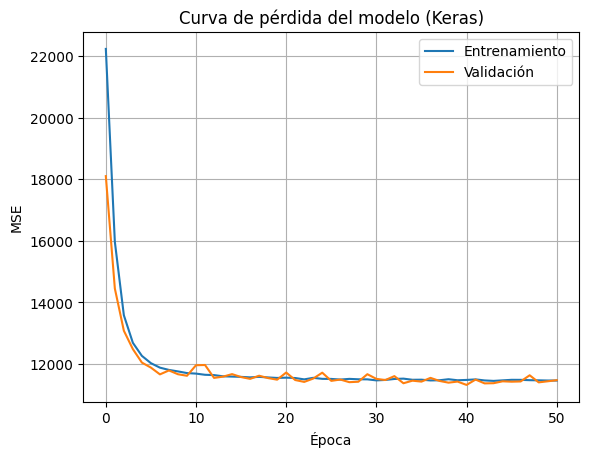

In [6]:
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.legend()
plt.title('Curva de pérdida del modelo (Keras)')
plt.grid(True)
plt.show()


### Reconstruct image

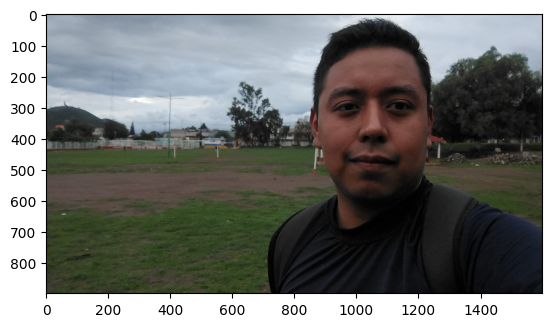

In [7]:
from PIL import Image
_path = os.getcwd()
# Subimos dos niveles para llegar a la carpeta raíz del proyecto
base_path = os.path.split(os.path.split(_path)[0])[0]
path_data = os.path.join(base_path, "data")

img = Image.open("/home/kingsman/Escritorio/Lenstronomy/lenstronomy-tutorials/Data/yop.jpeg")
image_array = np.asarray(img)
plt.imshow(image_array)
plt.show()

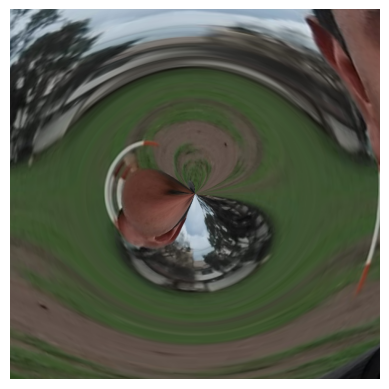

In [8]:
#colors
image_r = image_array[:, :, 0].astype(float)
image_g = image_array[:, :, 1].astype(float)
image_b = image_array[:, :, 2].astype(float)

# 1) Elegimos el perfil INTERPOL para cada canal
light_model_list = ["INTERPOL"]

# 2) Rojo (R)
light_model_r = LightModel(light_model_list=light_model_list)
kwargs_light_r = [{
    "image":   image_r,   # 2D array con canal rojo original
    "amp":     1,         # escala lineal (here 1 → toma valor directo)
    "center_x":0,         # ancla x del origen de 'image' en arcsec
    "center_y":0,         # ancla y
    "phi_G":   0,         # rotación del perfil (rad)
    "scale":   1          # factor que relaciona unidades de β con píxeles de 'image'
}]
image_r_lensed = light_model_r.surface_brightness(
    beta_x, beta_y, kwargs_light_r)

#same for green and blue
light_model_g = LightModel(["INTERPOL"])
kwargs_light_g = [{ "image": image_g, "amp":1, "center_x":0, "center_y":0, "phi_G":0, "scale":1 }]
image_g_lensed = light_model_g.surface_brightness(beta_x, beta_y, kwargs_light_g)

light_model_b = LightModel(["INTERPOL"])
kwargs_light_b = [{ "image": image_b, "amp":1, "center_x":0, "center_y":0, "phi_G":0, "scale":1 }]
image_b_lensed = light_model_b.surface_brightness(beta_x, beta_y, kwargs_light_b)

# 3) Reensamblar canales en una imagen RGB final
height, width = image_b_lensed.shape
image_lensed = np.zeros((height, width, 3), dtype=np.uint8)

image_lensed[:, :, 0] = image_r_lensed  # canal rojo
image_lensed[:, :, 1] = image_g_lensed  # canal verde
image_lensed[:, :, 2] = image_b_lensed  # canal azul

# 4) Mostrar
plt.imshow(image_lensed)
plt.axis('off')
plt.show()


In [9]:
h, w, _ = image_lensed.shape
deltapix = 1.0  # usar el mismo que usaste en la simulación

# Grilla de coordenadas (u,v) = plano lenteado
u, v = util.make_grid(numPix=w, deltapix=deltapix)
u_img = util.array2image(u)
v_img = util.array2image(v)

uv_coords = np.stack([u_img.ravel(), v_img.ravel()], axis=1)  # shape: (N_pix, 2)


In [10]:
#predecir las coordendas inversas plano fuente
xy_pred = model.predict(uv_coords)  # shape: (N_pix, 2)

x_pred = xy_pred[:, 0].reshape(h, w)
y_pred = xy_pred[:, 1].reshape(h, w)


11250/11250 [==============================] - 22s 2ms/step


In [11]:
from scipy.ndimage import map_coordinates

# Tu imagen original descompuesta en canales
# image_r, image_g, image_b (con shape h x w)

def interpolate_channel(channel, x_coords, y_coords):
    # map_coordinates espera las coords en orden (y, x) y normalizadas al índice
    coords = [y_coords, x_coords]  # orden (rows, cols)
    return map_coordinates(channel, coords, order=1, mode='reflect')

reconstructed_r = interpolate_channel(image_r, x_pred, y_pred)
reconstructed_g = interpolate_channel(image_g, x_pred, y_pred)
reconstructed_b = interpolate_channel(image_b, x_pred, y_pred)

# Reconstruir la imagen RGB
image_reconstructed = np.stack([reconstructed_r, reconstructed_g, reconstructed_b], axis=-1).astype(np.uint8)


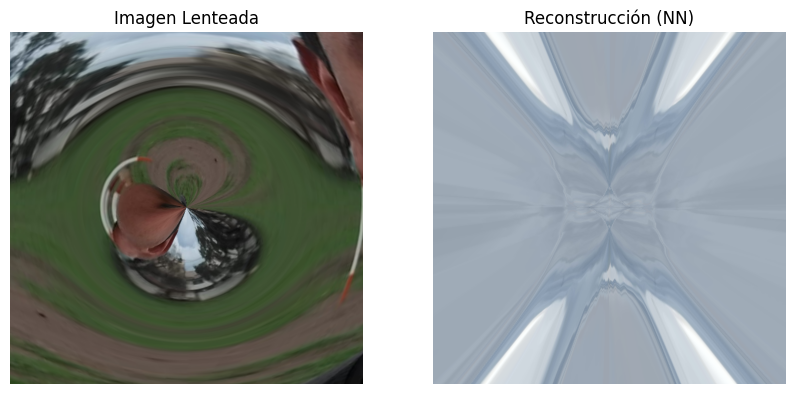

In [13]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Imagen Lenteada")
plt.imshow(image_lensed)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Reconstrucción (NN)")
plt.imshow(image_reconstructed)
plt.axis('off')
plt.show()
